In [1]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
#import matplotlib.pyplot as plt
#from matplotlib.gridspec import GridSpec
#from pylab import *
import seaborn as sns
%matplotlib inline

E:\python\anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


С чем нам придётся работать? Сразу же это подготовим - заменим female и male на 0 и 1 соответственно, а также заменим пропуски на средние.

In [2]:
df = pd.read_csv('titanic.csv', index_col='PassengerId')
df['Sex'] = df['Sex'].map({'female': 0, 'male':1}).astype(int)
df = df.fillna(df.mean())
df.head(8)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,22.000000,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000000,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",0,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000000,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",1,35.000000,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",1,29.699118,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",1,54.000000,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",1,2.000000,3,1,349909,21.0750,NaN,S


пол


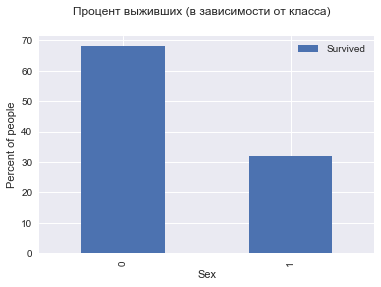

In [3]:
print('пол')

df_sex_survived = df.Sex[df.Survived == 1].value_counts()
data = df[df.Survived == 1]
n_data = data.groupby(['Sex']).agg({'Survived': 'count'})
new_data = n_data.groupby(level=0).apply(lambda x: round(100 * x / float(n_data['Survived'].sum()), 2))
plt.figure()
figure = new_data.plot(kind='bar')
figure.set_ylabel('Percent of people')
figure.set_xlabel('Sex')
plt.suptitle('Процент выживших (в зависимости от класса)', fontsize = 12)
plt.show()

класс


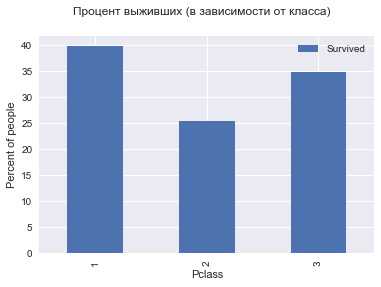

In [4]:
print('класс')

df_pclass_survived = df.Pclass[df.Survived == 1].value_counts()
data = df[df.Survived == 1]
n_data = data.groupby(['Pclass']).agg({'Survived': 'count'})
new_data = n_data.groupby(level=0).apply(lambda x: round(100 * x / float(n_data['Survived'].sum()), 2))
plt.figure()
figure = new_data.plot(kind='bar')
figure.set_ylabel('Percent of people')
figure.set_xlabel('Pclass')
plt.suptitle('Процент выживших (в зависимости от класса)', fontsize = 12)
plt.show()

выживаемость в зависимости от пола и класса


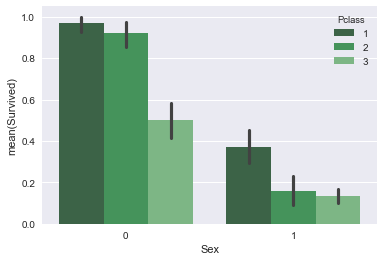

In [5]:
print('выживаемость в зависимости от пола и класса')
sns.barplot(x='Sex', y='Survived', hue='Pclass', data=df, palette='Greens_d')

средняя цена на билет в каждый класс
Axes(0.125,0.125;0.775x0.755)


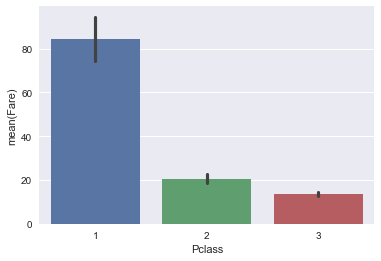

In [6]:
print('средняя цена на билет в каждый класс')
print(sns.barplot(x="Pclass", y="Fare",  data=df))

Что мы видим? А видим мы, что во-первых, у женщин при любом раскладе больше шансов на выживание. Во-вторых, второй класс наиболее опасен при кораблекрушении, третий класс где-то между, а первый - самый успешный. Это доказывает единение пролетариата с самыми главными буржуями и нарушает все марксистские каноны. Вероятность выживания женщины в любом классе, чем вероятность выживания мужчины хотя бы даже в первом. При этом средняя цена билета в первый класс в четыре раза выше таковой во второй, в то время как средняя цена билета в третий класс почти равна цене во второй. Не покупайте билеты для среднего класса со скидкой! И это в-третьих.

Теперь поубираем лишнее (name, ticket, cabin и embarked)

In [7]:
df = df.drop(['Name','Ticket','Cabin', 'Embarked'],1)
df.head(8)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,,,,,,,
1,0,3,1,22.000000,1,0,7.2500
2,1,1,0,38.000000,1,0,71.2833
3,1,3,0,26.000000,0,0,7.9250
4,1,1,0,35.000000,1,0,53.1000
5,0,3,1,35.000000,0,0,8.0500
6,0,3,1,29.699118,0,0,8.4583
7,0,1,1,54.000000,0,0,51.8625
8,0,3,1,2.000000,3,1,21.0750


В принципе, наличие тех или иных родственников может повлиять на выживаемость конкретного человека. В первую очередь матерей с детьми, поэтому Parch точно нужно оставлять. SibSp скорее всего никак не повлияет, но тоже пусть будет.

Теперь приступим к обучению

In [8]:
x_labels = ['Sex', 'Pclass', 'Age', 'Fare', 'SibSp', 'Parch']
X, y = df[x_labels], df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(668, 6) (223, 6) (668,) (223,)


In [9]:
dtc = DecisionTreeClassifier(max_depth=10, min_samples_split=24, min_samples_leaf=5)
dtc.fit(np.array(X_train), np.array(y_train))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=24, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [10]:
importances = pd.Series(dtc.feature_importances_, index=x_labels)
print(importances)

Sex       0.524998
Pclass    0.185516
Age       0.135572
Fare      0.100472
SibSp     0.053443
Parch     0.000000
dtype: float64


In [11]:
y_predict = dtc.predict(X_test)
print(classification_report(y_test, y_predict))

             precision    recall  f1-score   support

          0       0.89      0.82      0.85       152
          1       0.67      0.77      0.72        71

avg / total       0.82      0.81      0.81       223



Посредством перебора я пришёл вот к такому набору характеристик. Заметный рост всех показателей дало добавление признака Sex, который я сначала успешно забыл. Но кажется,что это вполне логично, так как вес параметра Sex больше, чем вес любого другого параметра. Можно было бы попробовать залезть в большие числа, но у меня была напряжёнка со временем

Повторим для случайного леса

In [13]:
rfc = RandomForestClassifier(n_estimators = 100)
rfc.fit(X_train, y_train)
y_predict = rfc.predict(X_test)
print(classification_report(y_test, y_predict))

             precision    recall  f1-score   support

          0       0.89      0.86      0.87       152
          1       0.71      0.77      0.74        71

avg / total       0.83      0.83      0.83       223



Случайный лес показал себя чуть получше, чем дерево решений. Не кардинально, но лучше. 